In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole, dipole_map, spherical_to_cartesian

### fit to CMB dipole

In [3]:
# Quaia map
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
map_quaia = tools.load_catalog_as_map(cat_fn, frame='icrs')

In [4]:
# selection function
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))

In [5]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
cmb_amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(cmb_amps, NSIDE) # match NSIDE with Quaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


### fit to CMB dipole and feature maps

In [6]:
# design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree

In [7]:
# weights
"""
WARNING: "magic number"
"""
# ! OLD covariance
# Cinv = 42 * selfunc

Cinv = 1. / np.clip(42 * selfunc, 1., None)  # set min value to 1

In [8]:
maps_forsel = []
map_names = ['dust', 'stars', 'm10', 'mcs']
for map_name in map_names:
    maps_forsel.append(np.load(f'/scratch/aew492/quasars/maps/map_{map_name}_NSIDE{NSIDE}.npy'))

In [9]:
# construct design matrix
fit_everything = True
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 6)

In [10]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [11]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [12]:
x_names = np.append(['completeness','CMB dipole * comp.'], map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.043264       	0.042055        	
CMB dipole * comp.	71.929164       	8.422380        	
dust            	4.530e-03       	1.539e-03       	
stars           	1.996e-05       	8.600e-06       	
m10             	-5.606e-03      	7.691e-04       	
mcs             	1.388e-04       	1.738e-04       	


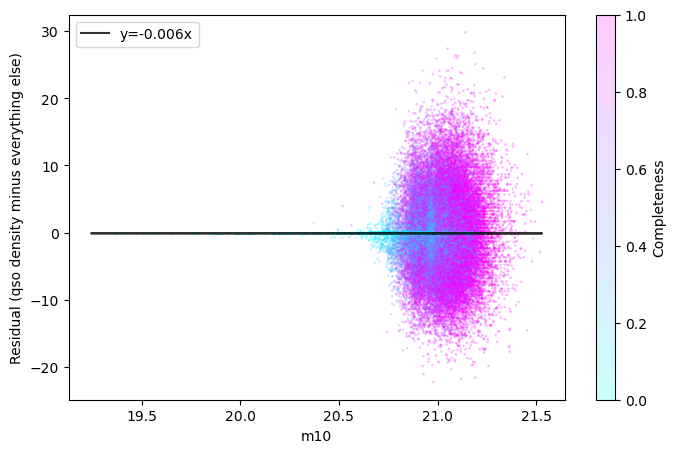

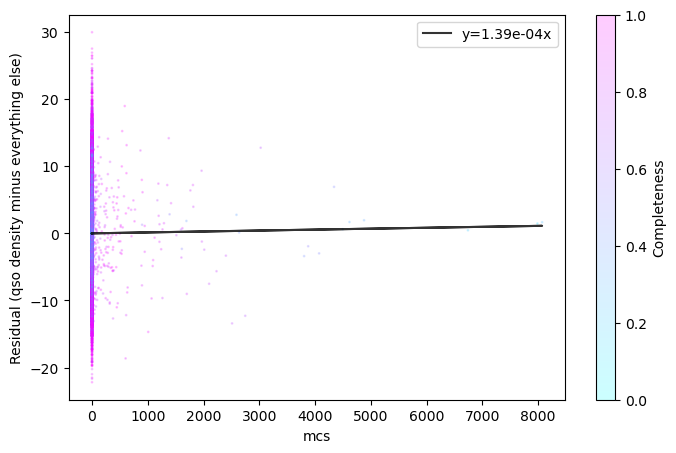

In [13]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    if x_names[i]=='stars' or x_names[i]=='mcs':
        label = f'y={slope:.2e}x'
    else:
        label = f'y={slope:.3f}x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend()
    fig.colorbar(s, label='Completeness')

### freeze the error model and refit just the CMB dipole

** what about this is "freezing the error model"? aren't we just fitting to only the CMB dipole like normal, forgetting any info from the simultaneous fit to the four feature maps?

In [14]:
# construct design matrix
fit_everything = False
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 2)

In [15]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [16]:
x_names = ['completeness','CMB dipole * comp.']
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	40.889333       	0.036432        	
CMB dipole * comp.	72.615097       	8.421875        	


### fit to the full dipole vector, without the feature maps

In [17]:
# check out three orthogonal dipole maps
template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3))))  # first column for the monopole
template_amps

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

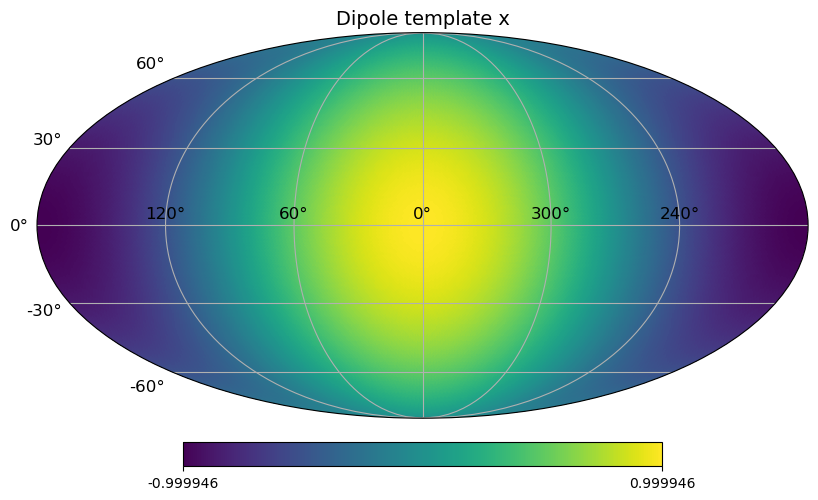

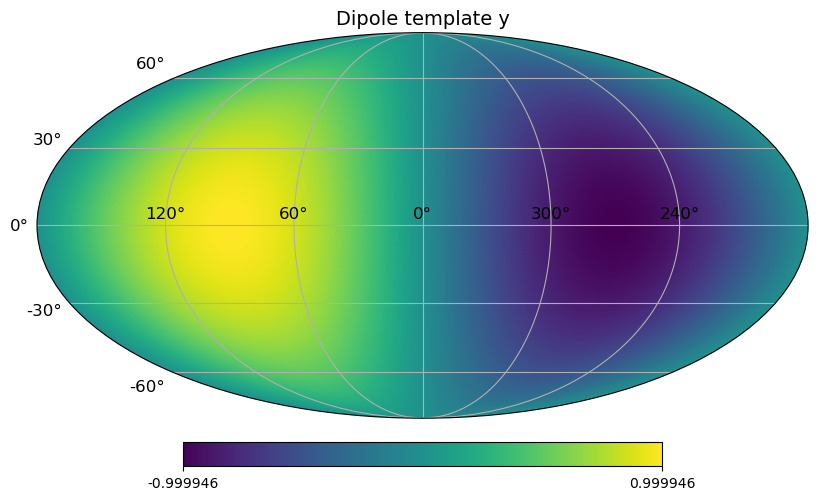

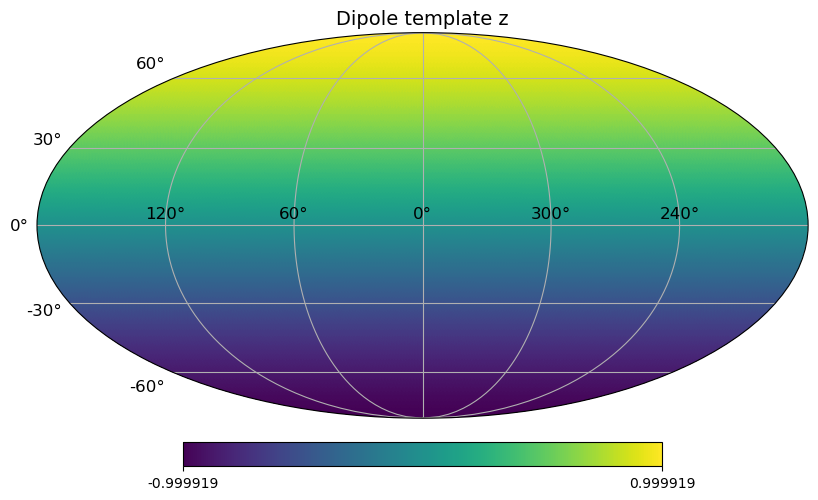

In [18]:
coords = ['x', 'y', 'z']
for i, amps in enumerate(template_amps):
    dipolemap = dipole_map(amps)
    tools.plot_map(dipolemap, title='Dipole template '+coords[i])

In [19]:
# now get the orthogonal component maps of the CMB dipole
cmb_template_amps = cmb_amps * template_amps
cmb_template_maps = np.array([dipole_map(amps) for amps in cmb_template_amps])

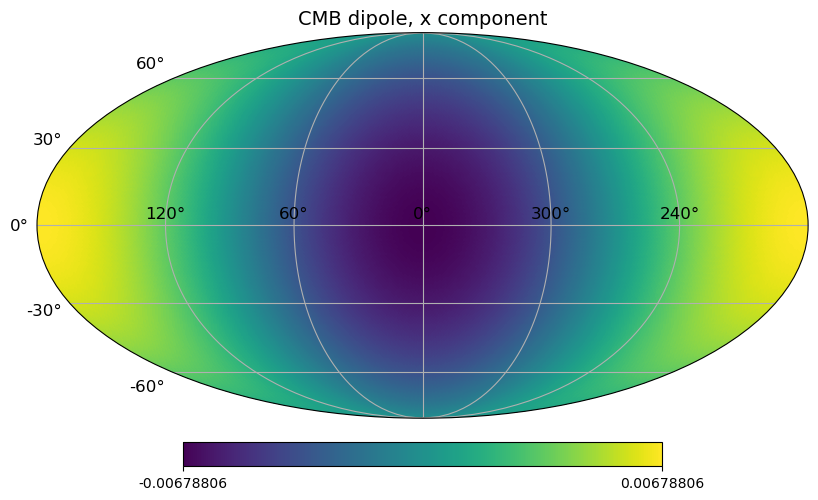

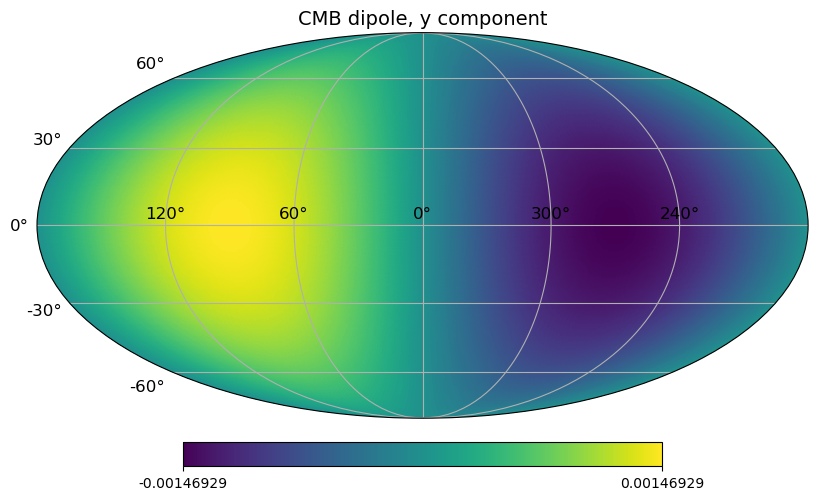

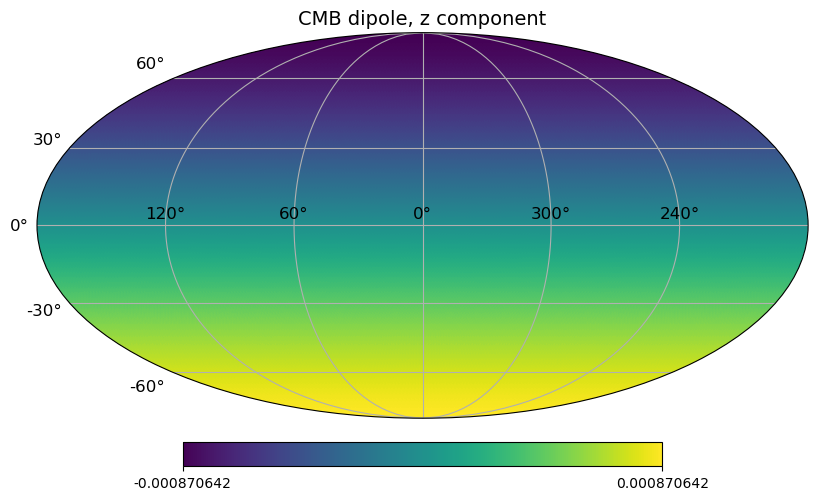

In [20]:
for i, cmbmap in enumerate(cmb_template_maps):
    tools.plot_map(cmbmap, title=f'CMB dipole, {coords[i]} component')

In [21]:
# check that the sum is actually the CMB dipole
cmbmap = np.sum(cmb_template_maps, axis=0)
tools.plot_map(cmbmap)

In [22]:
cmb_template_maps.shape

(3, 49152)

In [23]:
# construct design matrix
fit_everything = False
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), cmb_template_maps.T))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 4)

In [28]:
# perform the fit
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [29]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [32]:
x_names = np.append(['completeness'],[f'CMB dipole {coord} * comp.' for coord in coords])
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	40.9395         	0.0365          	
CMB dipole x * comp.	112.7584        	8.5602          	
CMB dipole y * comp.	-1135.8859      	47.9977         	
CMB dipole z * comp.	912.9030        	76.4662         	


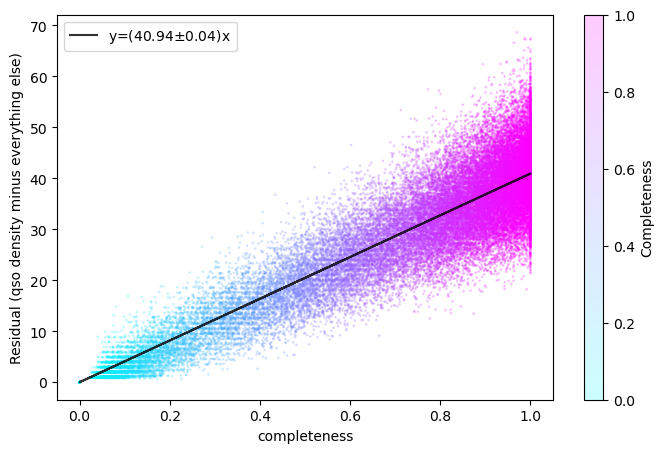

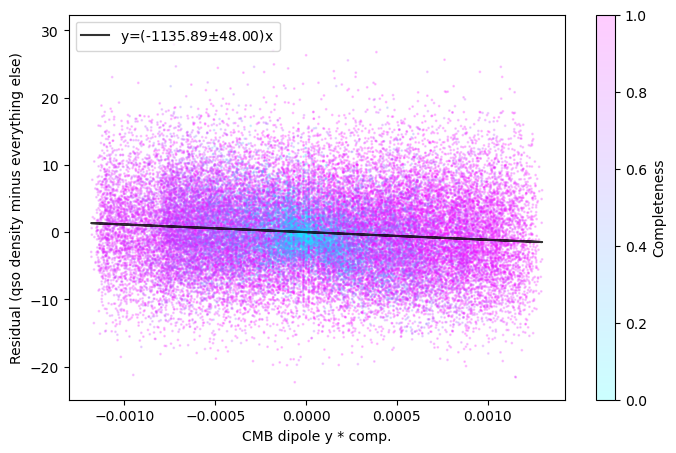

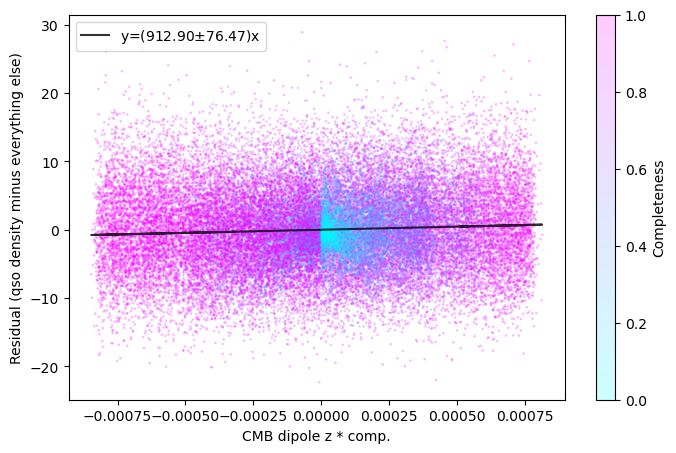

In [43]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    label = f'y=({slope:.2f}$\pm${bestfit_stderr[i]:.2f})x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend(loc=2)
    fig.colorbar(s, label='Completeness')

In [41]:
np.sum(bestfit_pars[1:])

-110.22456827749409

### fit to the full feature maps, with the four feature maps

In [44]:
# construct design matrix
fit_everything = True
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), cmb_template_maps.T))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 8)

In [45]:
# perform the fit
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [46]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [51]:
x_names = np.append(['completeness'], [f'CMB dipole {coord} * comp.' for coord in coords])
x_names = np.append(x_names, map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
            if i >= 5:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.1003         	0.0421          	
CMB dipole x * comp.	112.2441        	8.5607          	
CMB dipole y * comp.	-1142.2641      	48.0127         	
CMB dipole z * comp.	917.3111        	76.5467         	
dust            	4.967e-03       	1.539e-03       	
stars           	1.650e-05       	8.601e-06       	
m10             	-5.827e-03      	7.691e-04       	
mcs             	1.218e-04       	1.740e-04       	


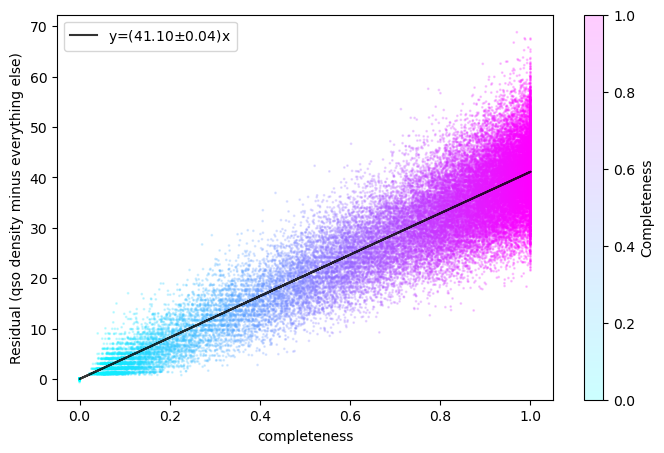

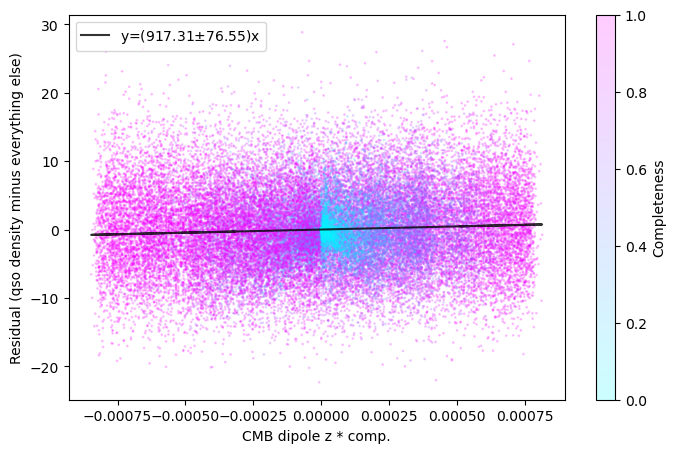

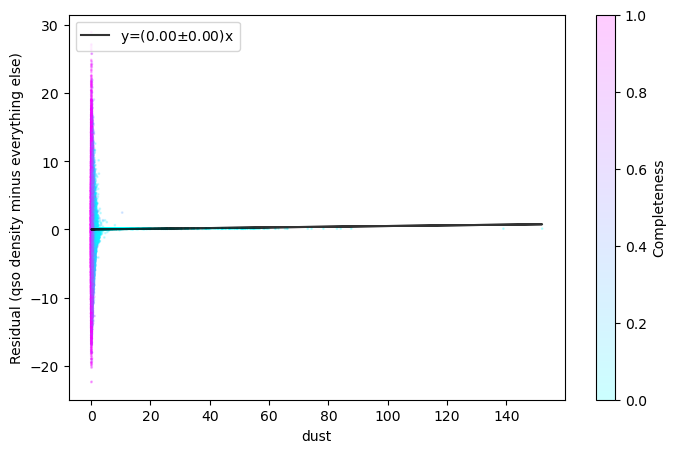

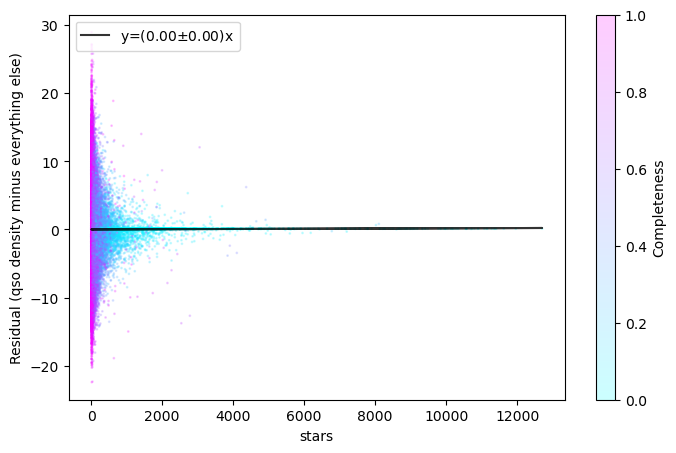

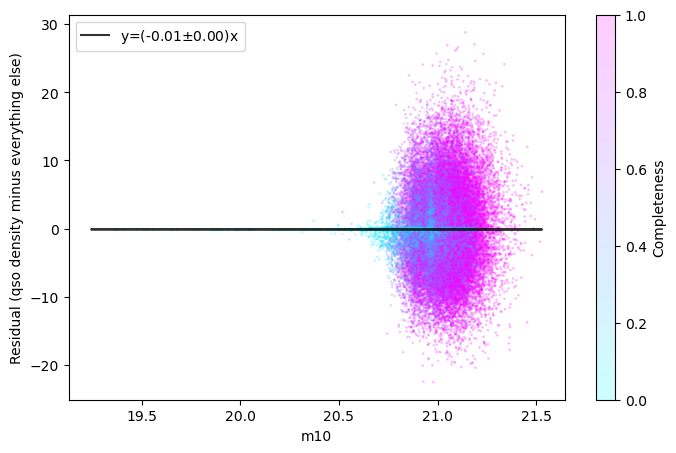

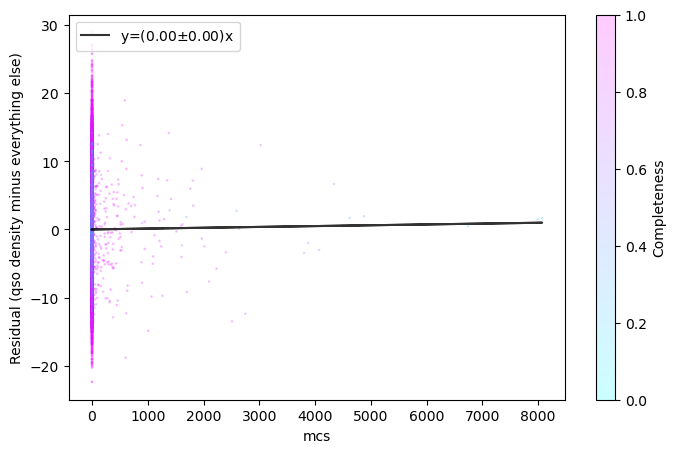

In [52]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    label = f'y=({slope:.2f}$\pm${bestfit_stderr[i]:.2f})x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend(loc=2)
    fig.colorbar(s, label='Completeness')